# Spam dataset analysis: train and test a logistic regressor

In this tutorial, the train and test of a logistic regressor will be demonstrated for the spam dataset.

## PRE-ANALYSIS 
Let's start with importing the necessary libraries for an initial pre-analysis:

In [1]:
from pathlib import Path
import pandas as pd
from text_analysis.read_write_data import read_data
from text_analysis.split_dataframe import split_dataframe
from text_analysis.cleantext import rename_columns, drop_empty_rows
from text_analysis.preanalysis import info_data, plot_label_distribution
from text_analysis.preanalysis import word_count_text, char_count_text
from text_analysis.preanalysis import average_word_or_chars
from text_analysis.preanalysis import plotting_word_char_count, printer_word_chars

[nltk_data] Downloading package omw-1.4 to /home/flavio/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flavio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/flavio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In the next step we will set the analysis name, which is the folder name that contains the data.
Then we set thee seed in order to have a deterministic behaviour and then we set the dataset folder path.

In [2]:
analysis_name = 'spam'
seed = 42
dataset_folder = Path('../datasets') / analysis_name
if not dataset_folder.is_dir():
    print('The dataset folder path links to a path which is not a folder!')

Let's see how many files there are inside the folder:

In [3]:
print(list(dataset_folder.glob('**/*.csv')))

[PosixPath('../datasets/spam/spam_encoded.csv')]


All the data are stored in one single dataset.
Now we can read the data inside the folder and then split the dataset.
We will obtain three different pandas dataframes: train, validation, test dataframe.

In [4]:
dfs_raw = read_data(dataset_folder)
train_fraction = 0.70
test_fraction = 0.15
# the first one has to be the train frac and the second one the test frac:
fractions = (train_fraction, test_fraction) 
df_train, df_val, df_test = split_dataframe(dfs_raw, fractions, seed)

Now let's find the inital column names for the text and labels.
Then we clean a little bit the dataframes: we remove rows with empty cells from the dataframes.

In [5]:
# FUNCTION FOR FINDING INITIAL COLUMN NAMES:
def find_initial_columns(analysis_name: str) -> tuple[str]:
    column_names_list = [{'analysis': 'covid',
                          'text_column': 'tweet',
                          'label_column': 'label'},
                          {'analysis': 'spam',
                           'text_column': 'original_message',
                           'label_column': 'spam'},
                           {'analysis': 'disaster',
                            'text_column': 'text',
                            'label_column': 'target'}]
    analysis_index = next((index for (index, d) in enumerate(column_names_list)
                                             if d["analysis"] == analysis_name), None)
    column_names = (column_names_list[analysis_index]['text_column'],
                    column_names_list[analysis_index]['label_column'])
    return column_names


In [6]:
text_col_name, label_col_name  = find_initial_columns(analysis_name)

df_new = []
for df in (df_train, df_val, df_test):
    # FIRST DROP ROWS WITH EMPTY CELLS AND RENAME THE COLUMNS WITH SOME STANDARD NAME: "text", "label"
    df_new.append(drop_empty_rows(rename_columns(df, text_col_name, label_col_name)))
    
df_train, df_val, df_test = df_new


Now we can ask some informations about the dataframes.
Then we plot label distribution.

In [7]:
info_data(df_train, df_val, df_test)

First five rows of train dataset
                                                text  label
0  House-Maid is the murderer, coz the man was mu...      0
1              Any pain on urination any thing else?      0
2                                        Lmao!nice 1      0
3                     What time you thinkin of goin?      0
4             Full heat pa:-) i have applyed oil pa.      0

Description of train dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3900 non-null   object
 1   label   3900 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 61.1+ KB

Description of validation dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    836 non-null    object
 1   label   836 non-null    


Train dataset label distribution:
0    3377
1     523
Name: label, dtype: int64

Valid dataset label distribution:
0    720
1    116
Name: label, dtype: int64

Test dataset label distribution:
0    728
1    108
Name: label, dtype: int64


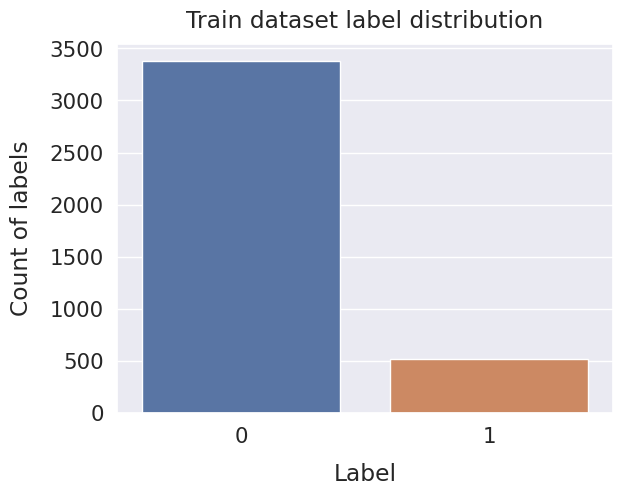

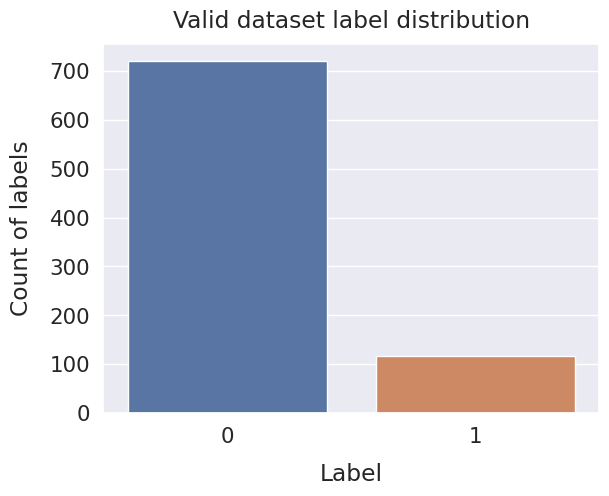

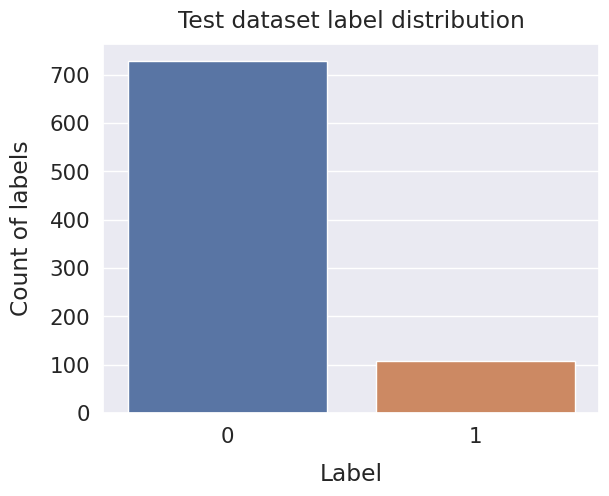

In [8]:
plot_label_distribution(df_train['label'], df_val['label'], df_test['label'])

Now we count how many words and characters for each message.

In [9]:
words_mean_list = []
chars_mean_list = []
for dataframe in (df_train, df_val, df_test):
    word_count = word_count_text(dataframe['text'])
    char_count = char_count_text(dataframe['text'])
    words_mean_list.append(average_word_or_chars(dataframe['label'], word_count))
    chars_mean_list.append(average_word_or_chars(dataframe['label'], char_count))
    dataframe['word_count'] = word_count
    dataframe['char_count'] = char_count

Now visualize the results just obtained.

In [10]:
printer_word_chars(words_mean_list, 'words')
printer_word_chars(chars_mean_list, 'chars')

0 labels length (average words):training 14.2 validation 14.0 test 14.5
1 labels length (average words):training 23.9 validation 23.4 test 24.1
0 labels length (average chars):training 70.7 validation 70.6 test 72.7
1 labels length (average chars):training 138.8 validation 137.6 test 140.7


Now we plot the word counts distribution and the character counts distribution in order to better
see the difference in word/characters length between spam and ham messages.

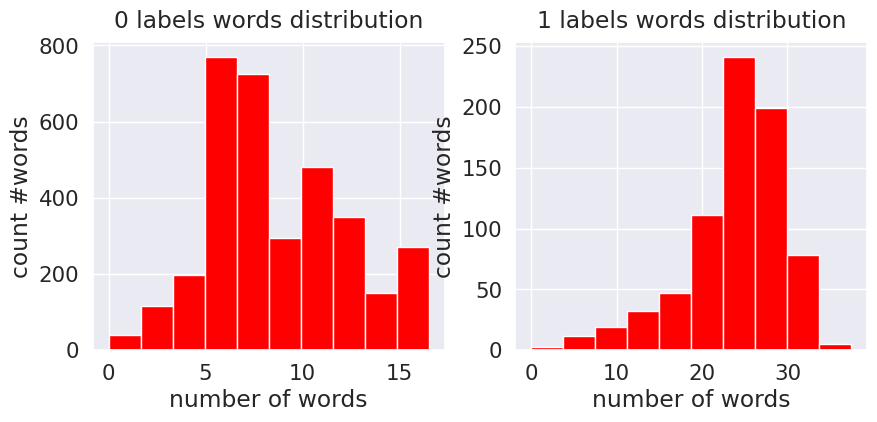

In [11]:
df_complete = pd.concat([df_train, df_val, df_test], ignore_index=True)
plotting_word_char_count(df_complete['label'], df_complete['word_count'], 'words')

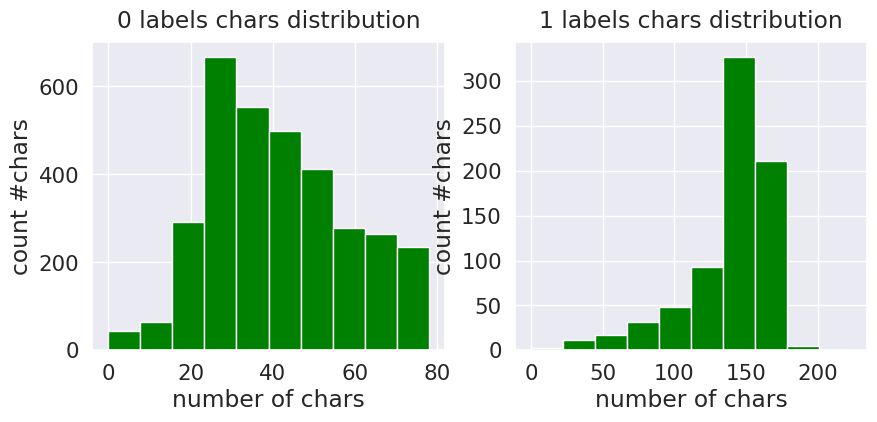

In [12]:
plotting_word_char_count(df_complete['label'], df_complete['char_count'], 'chars')

## PREPROCESS PART

We just finished the pre-analysis part and now we want to clean a little bit the text in order to make a better
analysis. Inisde the text there could be some characters that we don't want, for example: emoticons, URLs, tags, hastags, punctuations, special characters and so on.
Now we will clean the text, and we will save the new cleaned datasets in another folder (called preprocessed_datasets for example).

In [13]:
from tqdm import tqdm
from text_analysis.cleantext import finalpreprocess
from text_analysis.read_write_data import write_data

In [14]:
dfs_processed = []
for df in (df_train, df_val, df_test):
    df_cleaned = df.copy()
    df_cleaned = df_cleaned[['text', 'label']]
    
    # NEW COLUMN: "clean_text" -> CLEAN THE "text" column
    df_cleaned['clean_text'] = df_cleaned['text']
    cleaned_text = [finalpreprocess(text_to_clean) for text_to_clean in tqdm(df_cleaned['clean_text'])]
    df_cleaned['clean_text'] = cleaned_text
    df_cleaned = drop_empty_rows(df_cleaned)
    dfs_processed.append(df_cleaned)
df_train, df_val, df_test = dfs_processed

100%|████████████████████████████████████████| 836/836 [00:07<00:00, 110.44it/s]


(OPTIONAL) We can write the preprocessed datasets in a new folder.

In [15]:
output_folder = Path('../preprocessed_datasets') / analysis_name
output_folder.mkdir(parents=True, exist_ok=True)

write_data(dfs_processed, output_folder = output_folder, analysis = analysis_name)

Now let's print out some cleaned text.

In [16]:
print(df_train['clean_text'].head())
print("="*40)
print(df_val['clean_text'].head())
print("="*40)
print(df_test['clean_text'].head())

0    house maid murderer coz man murder lt gt th ja...
1                            pain urination thing else
2                                          lmao nice 1
3                                    time thinkin goin
4                            full heat pa apply oil pa
Name: clean_text, dtype: object
0                  u dun say early hor u c already say
1                  nah think go usf life around though
2    freemsg hey darling 3 week word back like fun ...
3    gon na home soon want talk stuff anymore tonig...
4                                 seriously spell name
Name: clean_text, dtype: object
0    funny fact nobody teach volcano 2 erupt tsunam...
1    sent score sophas secondary application school...
2    know someone know fancy call 09058097218 find ...
3       promise get soon text morning let know make ok
4    congratulation ur award either 500 cd gift vou...
Name: clean_text, dtype: object


In [18]:
print("Some random texts:\n" + "="*40)
for index, row in df_train.sample(n = 3).iterrows():
    print("\nOriginal text:\n" + "="*40) 
    print(row['text'])
    print("\nCleaned text:\n" + "="*40)
    print(row['clean_text'])

Some random texts:

Original text:
\Hi darlin did youPhone me? Im atHome if youwanna chat.\""

Cleaned text:
hi darlin youphone im athome youwanna chat

Original text:
K..then come wenever u lik to come and also tel vikky to come by getting free time..:-)

Cleaned text:
k come wenever u lik come also tel vikky come get free time

Original text:
Dear i am not denying your words please

Cleaned text:
dear denying word please


## TRAINING LOGISTIC REGRESSOR
Now we will vectorize data and then train a logistic regressor model.
Firstly we will import the needed functions.

In [17]:
from text_analysis.vectorize_data import get_vocabulary, tocat_encode_labels, vectorize_X_data_lr
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
import pickle # to save the LR model

2022-12-04 14:16:56.423630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 14:16:58.903674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flavio/root/lib
2022-12-04 14:16:58.904176: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flavio/root/lib
2022-12-04 14:16:58.904246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Now we set some parameters: embedding_vector_size is the output vector size after the vectorization,
min_count_words_w2v is the minimum occurencies number that a word needs to compare in the text, so that 
to be added in the vocabulary, checkpoint_path which is the checkpoin path where to save the logistic regressor model.

In [30]:
embedding_vector_size = 64
min_count_words_w2v = 3
checkpoint_path = Path('../checkpoint') / analysis_name # checkpoint path, where to save the LR model

Now we will generate a Word2Vec model starting from the vocabulary (all the single words).

In [31]:
all_train_words = list(df_train['clean_text']) + list(df_val['clean_text'])
vocabulary = get_vocabulary(all_train_words)

modelw2v = Word2Vec(vocabulary, vector_size=embedding_vector_size, window=5,
                         min_count=min_count_words_w2v, workers=1, seed = seed)  

Now we will vectorize the data.

In [32]:
df_train_val = pd.concat([df_train, df_val], ignore_index = True)
X_train = vectorize_X_data_lr(df_train_val['clean_text'], modelw2v)
y_train = tocat_encode_labels(df_train_val['label'])

Now we can train the logistic regressor model, save the Word2Vec model and then save also the logistic regressor model.

In [33]:
checkpoint_path.mkdir(parents = True, exist_ok = True)
file_path_model_w2v = checkpoint_path / 'word2vec.model'
modelw2v.save(str(file_path_model_w2v))

file_path_model_lr = checkpoint_path / 'logistic_regression.sav'

# TRAIN
print("Train logistic regressor...")
lr_w2v = LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2', max_iter=20)
lr_w2v.fit(X_train, y_train)
print("Logistic Regression: training done")
    
# SAVING MODEL
with open(file_path_model_lr, 'wb') as file:
    pickle.dump(lr_w2v, file)

Train logistic regressor...
Logistic Regression: training done


## EVALUATE LOGISTIC REGRESSOR MODEL

At this point we can evaluate the logistic regressor model with the test dataset.
We will load the Word2Vec model from the folder where we save it.
Then we will also load the Logistic Regressor model to test it.
Firstly import the needed functions.

In [24]:
from text_analysis.results import visualize_results

Now we define some paths to save the plots we will generate.

In [25]:
plot_path = Path('../plots') / analysis_name
plot_path.mkdir(parents = True, exist_ok = True)
checkpoint_path = Path('../checkpoint') / analysis_name
if not checkpoint_path.is_dir():
    print('The checkpoint folder path links to a path which is not a folder!')

Now load the Word2Vec and Logistic Regressor models (this part in this tutorial could be optional if we have just trained the models, but in the evaluation script the train and evaluation part are separated, so it's necessary to load the models in the evaluation script).

In [34]:
file_path_model_w2v = checkpoint_path / 'word2vec.model'
modelw2v = Word2Vec.load(str(file_path_model_w2v))

file_path_lr = checkpoint_path / 'logistic_regression.sav'
with open(file_path_lr, 'rb') as file:
    lr_w2v = pickle.load(file)

Vectorization of the text data; label encoding of the labels.

In [35]:
X_test  = vectorize_X_data_lr(df_test['clean_text'], modelw2v)
y_test, classes  = tocat_encode_labels(df_test['label'], classes = True)

Now we can see which words are the most common ones.

In [36]:
keyed_vectors = modelw2v.wv  # structure holding the result of training
print("The three most common words:")
for word in keyed_vectors.index_to_key[:3]:
    print(word)

The three most common words:
u
get
call


Now we can test the logistic regressor model.
We make predictions of the labels and then we plot them in a confusion matrix.

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       727
           1       0.74      0.24      0.36       108

    accuracy                           0.89       835
   macro avg       0.82      0.61      0.65       835
weighted avg       0.88      0.89      0.87       835

Confusion Matrix: [[718   9]
 [ 82  26]]
AUC: 0.9409610779968414


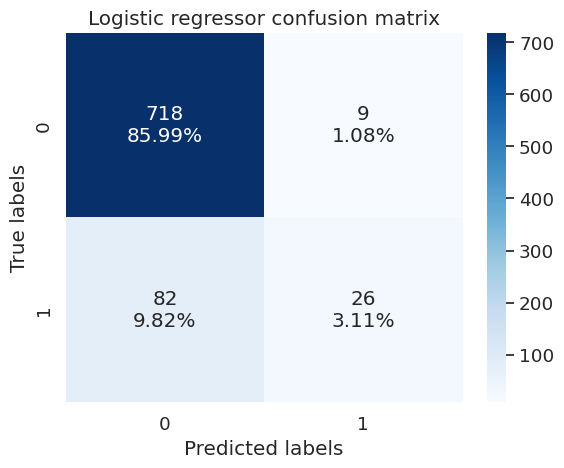

Logistic regressor model, accuracy: 89.10%


In [37]:
y_predict = lr_w2v.predict(X_test)
y_prob = lr_w2v.predict_proba(X_test)[:,1] # prob to belong to class 0 or 1
    
acc = lr_w2v.score(X_test, y_test)
visualize_results(y_test, y_predict, y_prob, list(classes),
                  name_model = 'Logistic regressor', folder_path=plot_path)
print("Logistic regressor model, accuracy: {:5.2f}%".format(100 * acc))

We have obtained a Logistic Regressor model (using a Word2Vec model for embedding) with an 89% of accuracy! 